# Browser as a tool
we can supply truly live information, you can connect a browser to provide up-to-the-minute data and smart exploration.
- Requesting live data using a browser tool with the Live API
- Returning images of web pages from function calling
- Connecting to a local network/intranet using a browser tool

## 1. Setup

In [ ]:
%pip install -U -q 'google-genai'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 3.9 MB/s eta 0:00:00


In [ ]:
from google.colab import userdata
from google import genai
GOOGLE_API_KEY = "GOOGLE_API_KEY"

In [ ]:
from google.genai import types

client = genai.Client(api_key=GOOGLE_API_KEY, http_options={'api_version': 'v1alpha'})

MODEL = 'gemini-2.0-flash-exp'  # @param ['gemini-2.0-flash-exp'] {allow-input: true, isTemplate: true}


## 2. Define Functionss

In [ ]:
import json
from urllib.robotparser import RobotFileParser # for parsing files which websites uses
from urllib.parse import urlparse # for working with url(extracting path  or hostname)

from IPython.display import display, HTML, Markdown


def show_parts(r: types.GenerateContentResponse) -> None:
  """Helper for rendering a GenerateContentResponse object in IPython.
   It's take ai responsea and display it in user friendlt wat"""

  # Extract parts of response
  parts = r.candidates[0].content.parts
  # If the response in none
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return

  for part in parts:
    if part.text: # if parts have text display it using markdown
      display(Markdown(part.text))
    elif part.executable_code: # Display code
      display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    else: #  if its neither convert to json
      print(json.dumps(part.model_dump(exclude_none=True), indent=2))
  grounding_metadata = r.candidates[0].grounding_metadata

  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))

In [ ]:
def can_crawl_url(url: str, user_agent: str = "*") -> bool:
    """Look up robots.txt for a URL and determine if crawling is permissable.

    Args:
        url: The full URL to check.
        user_agent: The user agent to check, defaults to any UA.

    Returns:
        True if the URL can be crawled, False otherwise.
    """
    try:
      parsed_url = urlparse(url)
      robots_url = f"{parsed_url.scheme}://{parsed_url.netloc}/robots.txt"
      rp = RobotFileParser(robots_url) # to read the file
      rp.read()

      return rp.can_fetch(user_agent, url) # Chechs if user is allowed to access

    except Exception as e:
      print(f"Error checking robots.txt: {e}")
      return False  # Be a good citizen: fail closed.

## 3. Use Google search as a tool

In [ ]:
config = {
    'response_modalities': ['TEXT'], # Type of response expected from model
    'tools': [
        {'google_search': {}},  # Tools model can access
    ],
}

async def stream_response(stream, *, tool=None):
  """Handle a live streamed response, printing out text and issue tool calls."""
  all_responses = []

  async for msg in stream.receive():
    all_responses.append(msg)

    if text := msg.text:  # If message contain text content
      # Print streamed text responses.
      print(text, end='')

    elif tool_call := msg.tool_call: # If message contain tool call
      # Handle tool calls.
      for fc in tool_call.function_calls:
        print(f'< Tool call', fc.model_dump(exclude_none=True))

        if tool:
          # Call the tool.
          assert fc.name == tool.__name__, "Unknown tool call encountered"
          tool_result = tool(**fc.args)

        else:
          # Return 'ok' as a way to mock tool calls.
          tool_result = 'ok'

        tool_response = types.LiveClientToolResponse(
            function_responses=[types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': tool_result},
            )]
        )

        await stream.send(input=tool_response) #  Sends the response to model through stream

  return all_responses



In [ ]:
async def run():
  async with client.aio.live.connect(model=MODEL, config=config) as stream:

    await stream.send(input="What is today's top 10 featured news in India", end_of_turn=True)
    await stream_response(stream)

await run()

Here's a breakdown of the top news headlines in India today, April 3, 2025:

**National News:**

*   **Waqf Bill:** The Waqf (Amendment) Bill is a major point of discussion, with debates in the Rajya Sabha. Some parties are opposing the bill, while the government insists it won't infringe on Muslim rights. There have been social media campaigns and protests regarding the bill.
*   **India-Thailand Ties:** India and Thailand have upgraded their relationship to a strategic partnership, with Prime Minister Modi meeting his Thai counterpart.
*   **Ceasefire Violation:** Pakistan violated the ceasefire in Jammu and Kashmir's Poonch sector, marking the second violation in three days.
*   **Supreme Court:** The Supreme Court has held the Telangana Chief Secretary accountable for deforestation. The court also stated that it is important to ensure that the Tenth Schedule is not reduced to a mockery.
*   **US Tariffs:** The Indian government is assessing the impact of the US's reciprocal tariffs

## 4. Add a Live browser

In [ ]:
%pip install -q markdownify

In [ ]:
import requests

import markdownify


def load_page(url: str) -> str:
  """
  Load the page contents as Markdown.
  """

  if not can_crawl_url(url):
    return f"URL {url} failed a robots.txt check."

  try:
    page = requests.get(url)
    return markdownify.markdownify(page.content)

  except Exception as e:
    return f"Error accessing URL: {e}"

In [ ]:
load_page_def = types.Tool(functionDeclarations=[
    types.FunctionDeclaration.from_callable(client=client, callable=load_page)]).model_dump(exclude_none=True)

config = {
    'response_modalities': ['TEXT'],
    'tools': [
        load_page_def,
    ],
    'system_instruction': """Your job is to answer the users query using the tools available.

First determine the address that will have the information and tell the user. Then immediately
invoke the tool. Then answer the user.
"""
}

In [ ]:
async def run():
  async with client.aio.live.connect(model=MODEL, config=config) as stream:

    await stream.send(input="What is today's featured article on the English Wikipedia?", end_of_turn=True)
    await stream_response(stream, tool=load_page)

await run()



I can help you with that! I will use the `load_page` tool to get the content of the English Wikipedia main page, which will contain the featured article.
< Tool call {'id': 'function-call-15854388928890828174', 'args': {'url': 'https://en.wikipedia.org/'}, 'name': 'load_page'}
Today's featured article on the English Wikipedia is about **Big Butte Creek**, a tributary of the Rogue River in Oregon.


## 5. Browse Pages visually
### Define a graphical browser

Here you define a browse_url function that uses Selenium to load a headless web browser, navigate to a URL and take a screenshot. This technique takes a single screenshot at a fixed size. There are other tools, such as selenium-screenshot, that can capture full-length images by repeatedly scrolling and capturing the page. As this tool is intended for use during a live conversation, this example uses the faster single-shot approach.

In [ ]:
!apt install -y chromium-browser
%pip install -q selenium webdriver-manager

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  apparmor libfuse3-3 libudev1 snapd squashfs-tools systemd-hwe-hwdb udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser libfuse3-3 snapd squashfs-tools systemd-hwe-hwdb udev
The following packages will be upgraded:
  libudev1
1 upgraded, 7 newly installed, 0 to remove and 29 not upgraded.
Need to get 30.3 MB of archives.
After this operation, 123 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.4 [598 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 squashfs-tools amd64 1:4.5-3build1 [159 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libudev1 amd64 249.11-0ubuntu3.15 [76.6 kB]
Get:4 http://archive.ubuntu.com/ub

In [ ]:
import time
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager

SCREENSHOT_FILE = 'screenshot.png'


def browse_url(url: str) -> str:
    """Captures a screenshot of the webpage at the provided URL.

    A graphical browser will be used to connect to the URL provided,
    and generate a screenshot of the rendered web page.

    Args:
        url: The full absolute URL to browse/screenshot.

    Returns:
        "ok" if successfully captured, or any error messages.
    """
    if not can_crawl_url(url):
      return f"URL {url} failed a robots.txt check."

    try:
      chrome_options = webdriver.ChromeOptions()
      chrome_options.add_argument('--headless')
      chrome_options.add_argument('--no-sandbox')
      chrome_options.headless = True
      driver = webdriver.Chrome(options=chrome_options)

      # Take one large image, 2x high as it is wide. This should be enough to
      # capture most of a page's interesting info, and should capture anything
      # designed "above the fold", without going too deep into things like
      # footer links, infinitely scrolling pages, etc.
      # Otherwise multiple images are needed, which requires waiting, scrolling
      # and stitching, and introduces lag that slows down interactions.
      driver.set_window_size(1024, 2048)
      driver.get(url)

      # Wait for the page to fully load.
      time.sleep(5)
      driver.save_screenshot(SCREENSHOT_FILE)

      print(f"Screenshot saved to {SCREENSHOT_FILE}")
      return "ok"

    except Exception as e:
      print(f"An error occurred: {e}")
      return str(e)

    finally:
      # Close the browser
      if driver:
        driver.quit()

In [ ]:
url = "https://en.wikipedia.org/wiki/Castle"
browse_url(url)

Screenshot saved to screenshot.png


'ok'

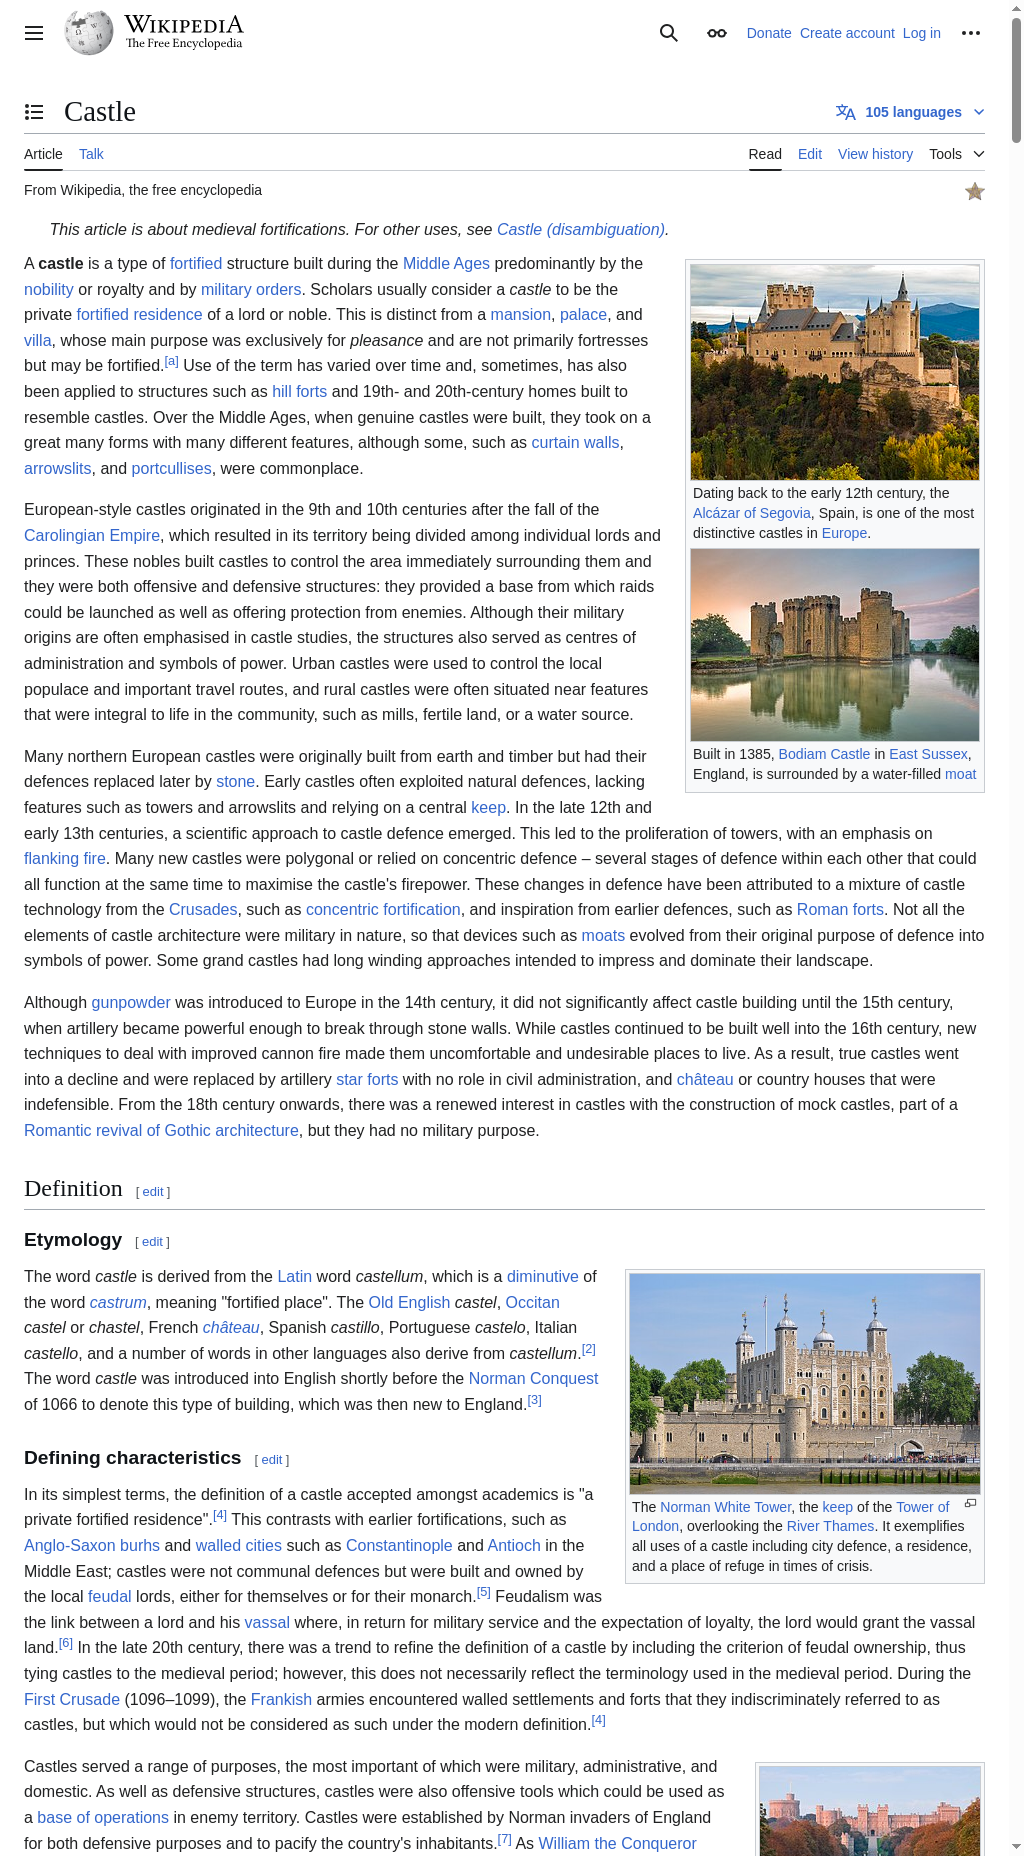

In [ ]:
from IPython.display import Image

Image('screenshot.png')

In [ ]:
url = "https://www.yahoo.com/?guccounter=1"
browse_url(url)

Screenshot saved to screenshot.png


'ok'

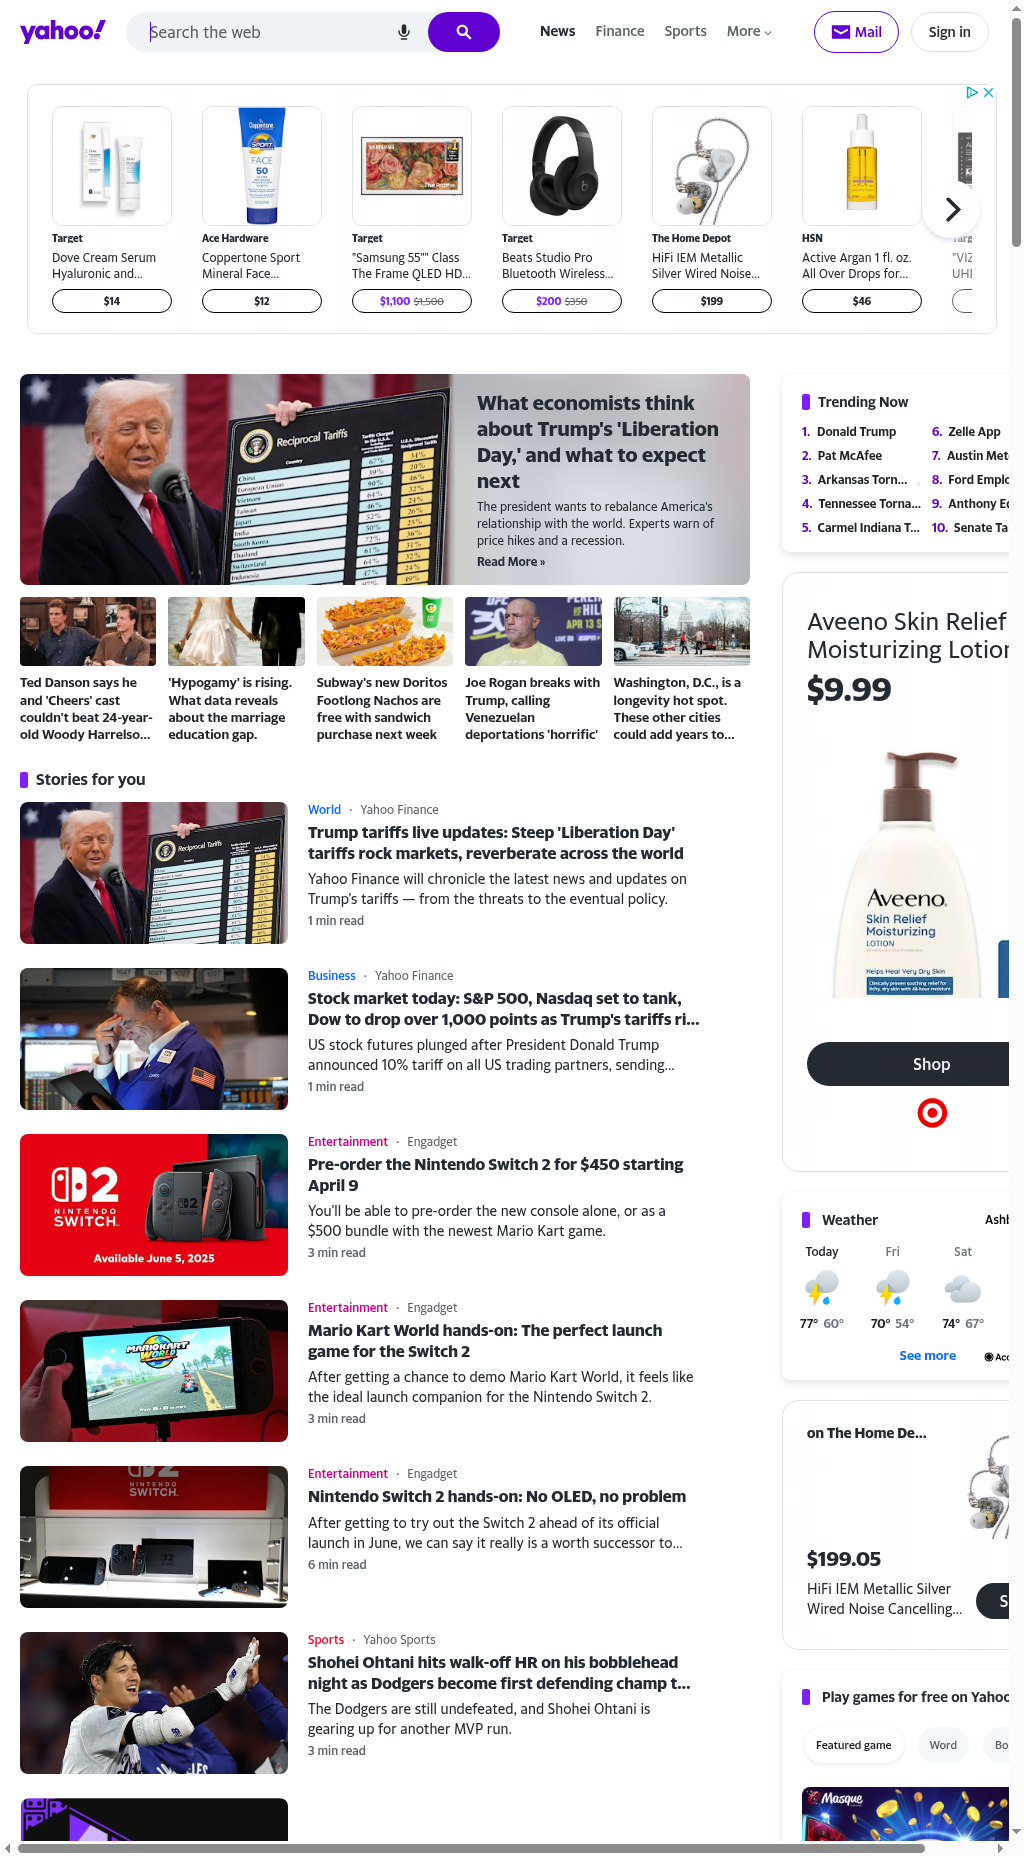

In [ ]:
from IPython.display import Image

Image('screenshot.png')

## 6. Connect the Browser to model

In [ ]:

sys_int = """You are a system with access to websites via the `browse_url` tool.
Use the `browse_url` tool to browse a URL and generate a screenshot that will be
returned for you to see and inspect, like using a web browser.

When a user requests information, first use your knowledge to determine a specific
page URL, tell the user the URL and then invoke the `browse_tool` with this URL. The
tool will supply the website, at which point you will examine the contents of the
screenshot to answer the user's questions. Do not ask the user to proceed, just act.

You will not be able to inspect the page HTML, so determine the most specific page
URL, rather than starting navigation from a site's homepage.
"""

# Because `browse_url` generates an image, and images can't be used in function calling
# (but can be used in regular Content/Parts), automatic function calling can't be used and
# the tool must be specified explicitly, and handled manually.
browse_tool = types.Tool(functionDeclarations=[
    types.FunctionDeclaration.from_callable(client=client, callable=browse_url)])

chat = client.chats.create(
    model=MODEL,
    config={'tools': [browse_tool], 'system_instruction': sys_int})

r = chat.send_message('What is trending on YouTube right now?')
show_parts(r)

I do not have the ability to directly access the YouTube trending page. However, I can access a specific URL if you provide it. To find the YouTube trending page, I would suggest searching "YouTube trending" on Google, finding the official YouTube trending page link, and then providing me with that URL. Then I can use the browse tool to access the page and tell you what's trending.


In [ ]:
chat.send_message('yes ,please use the tool')

GenerateContentResponse(candidates=[Candidate(content=Content(parts=[Part(video_metadata=None, thought=None, code_execution_result=None, executable_code=None, file_data=None, function_call=None, function_response=None, inline_data=None, text='Please provide the URL for the YouTube trending page. I need the specific URL to use the browse tool.\n')], role='model'), citation_metadata=None, finish_message=None, token_count=None, finish_reason=<FinishReason.STOP: 'STOP'>, avg_logprobs=-0.09424670176072554, grounding_metadata=None, index=None, logprobs_result=None, safety_ratings=None)], create_time=None, response_id=None, model_version='gemini-2.0-flash-exp', prompt_feedback=None, usage_metadata=GenerateContentResponseUsageMetadata(cache_tokens_details=None, cached_content_token_count=None, candidates_token_count=22, candidates_tokens_details=[ModalityTokenCount(modality=<MediaModality.TEXT: 'TEXT'>, token_count=22)], prompt_token_count=337, prompt_tokens_details=[ModalityTokenCount(modalit

In [ ]:
import PIL

url = "https://www.youtube.com/feed/trending"

response_parts = []

# For each function call, generate the response in two parts. Once for the
# function response, and one for the image as regular content. This simulates
# the function "returning" an image to the model as part of a function call.
for p in r.candidates[0].content.parts:
  # Check if the part is a function call and if its name is 'browse_url'
  if isinstance(p, types.Part) and p.function_call and p.function_call.name == 'browse_url':
    fn = p.function_call

    url = fn.args['url']
    print(url)
    response = browse_url(url)
    print(response)

    img = PIL.Image.open(SCREENSHOT_FILE)

    fr = genai.types.Part(function_response=genai.types.FunctionResponse(
        name=fn.name,
        id=fn.id,
        response={'result': response},
    ))
    # Append the function response and the image to response_parts
    response_parts.extend([fr, genai.types.Part(image=img)])
  # If not a browse_url function call, append the original part to keep the context.
  else:
      response_parts.append(p)

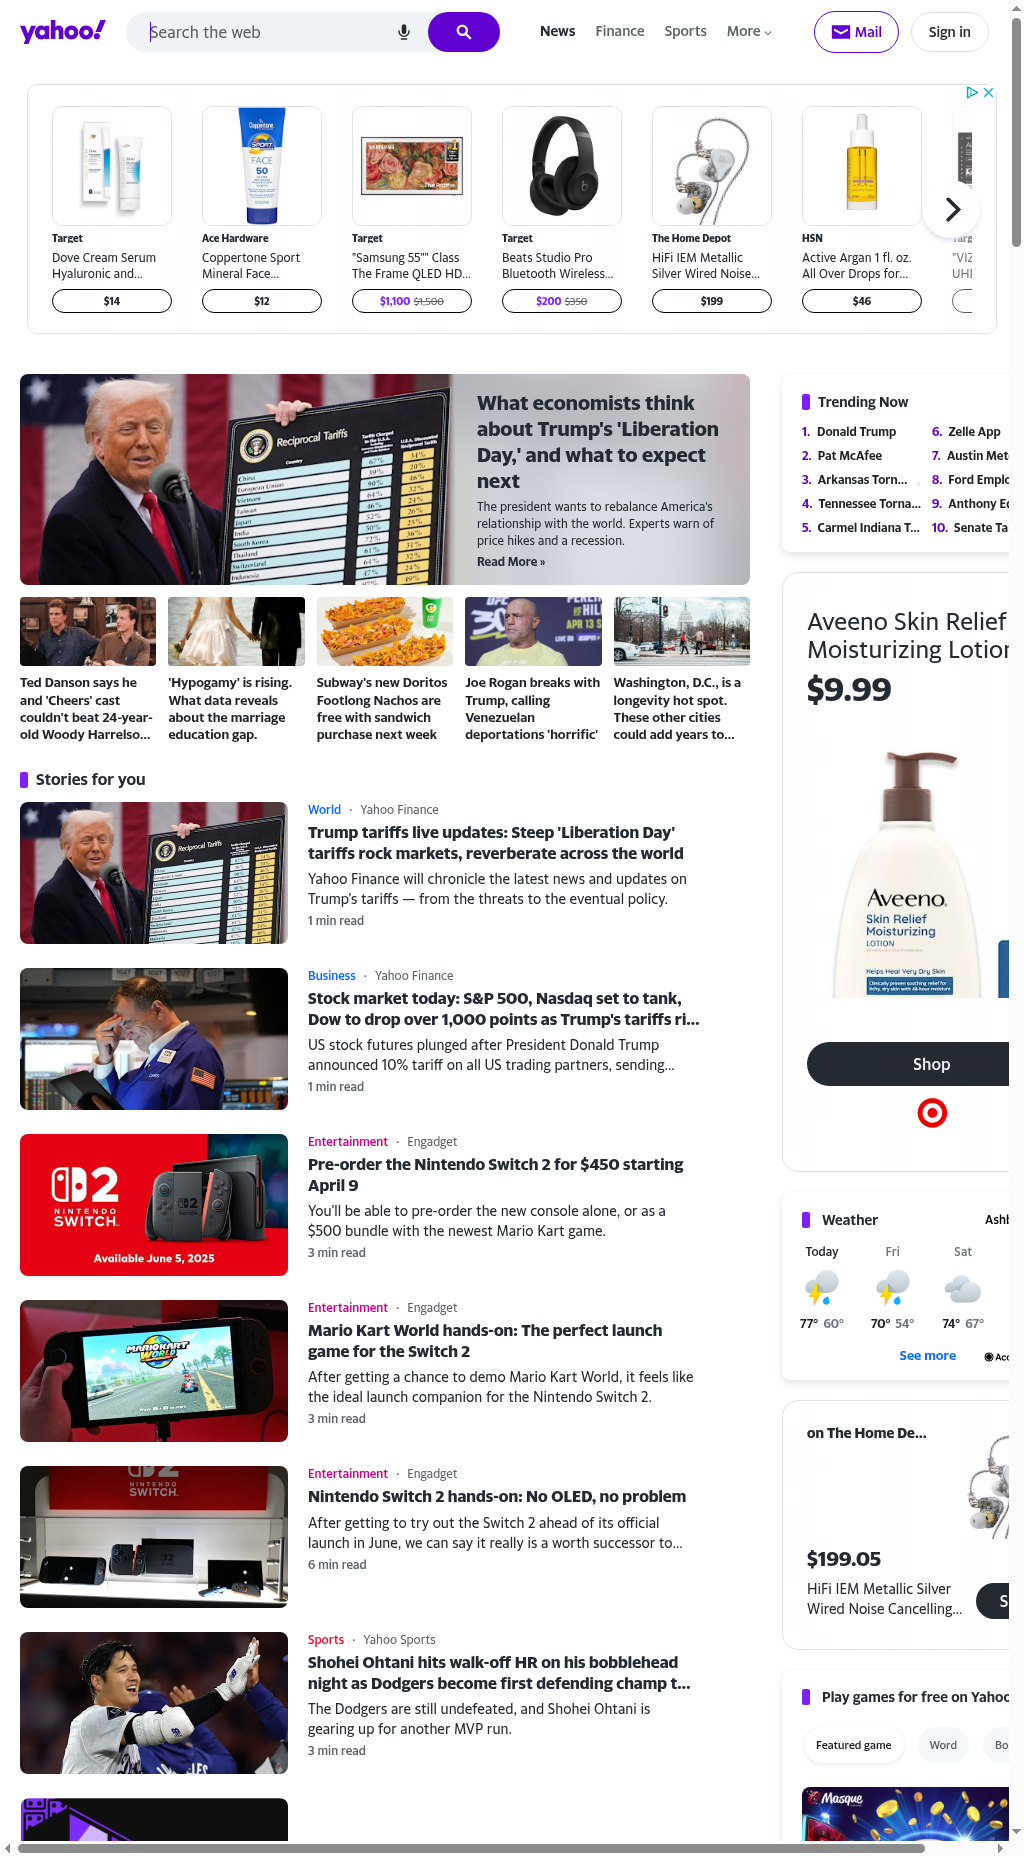

In [ ]:

Image(SCREENSHOT_FILE)

In [ ]:
r2 = chat.send_message(response_parts)
show_parts(r2)

You're right, I apologize. I need to find the URL myself. I will use Google to search for the YouTube trending page URL. Then I will use the browse tool with that URL.

Okay, I believe the correct URL is https://www.youtube.com/feed/trending. I will now use the browse tool to access this page.


{
  "function_call": {
    "args": {
      "url": "https://www.youtube.com/feed/trending"
    },
    "name": "browse_url"
  }
}


## 7. Browse local services
By providing a browse tool that you run in your own environment, you can connect it to your own private services - such as your home network or intranet.

In [ ]:
!wget -nv https://storage.googleapis.com/generativeai-downloads/data/intranet.zip
!unzip intranet.zip

2025-04-03 15:04:45 URL:https://storage.googleapis.com/generativeai-downloads/data/intranet.zip [168843/168843] -> "intranet.zip" [1]
Archive:  intranet.zip
   creating: intranet/
  inflating: intranet/logo.png       
  inflating: intranet/index.html     
  inflating: intranet/it.html        
  inflating: intranet/news.html      
  inflating: intranet/sitemap.xml    
  inflating: intranet/departments.html  
  inflating: intranet/hr.html        
 extracting: intranet/robots.txt     


Set up a HTTP server that serves those files in a background thread, so that you can access it using the main foreground thread.

In [ ]:
import http.server
import os
import socketserver
import threading


PORT = 80
DIRECTORY = "./intranet/"

class Handler(http.server.SimpleHTTPRequestHandler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, directory=DIRECTORY, **kwargs)

httpd = socketserver.TCPServer(("", PORT), Handler)
server_thread = threading.Thread(target=httpd.serve_forever)
server_thread.start()

In [ ]:
!echo "127.0.0.1 papercorp" >> /etc/hosts
!curl http://papercorp:{PORT}/

<!DOCTYPE html>
<!--
Copyright 2025 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
-->
<html>
<head>
  <title>Welcome to PaperCorp Intranet</title>
  <style>
    body {
      font-family: sans-serif;
    }
    .header {
      background-color: #f2f2f2;
      padding: 20px;
      text-align: center;
    }
    .logo {
      max-width: 200px;
    }
    .content {
      padding: 20px;
    }
    .news {
      float: left;
      width: 60%;
    }
    .announcements {
      float: right;
      width: 30%;
    }


127.0.0.1 - - [03/Apr/2025 15:05:42] "GET / HTTP/1.1" 200 -


127.0.0.1 - - [03/Apr/2025 15:05:56] "GET /robots.txt HTTP/1.1" 200 -
127.0.0.1 - - [03/Apr/2025 15:05:58] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Apr/2025 15:05:58] "GET /logo.png HTTP/1.1" 200 -
127.0.0.1 - - [03/Apr/2025 15:05:58] code 404, message File not found
127.0.0.1 - - [03/Apr/2025 15:05:58] "GET /favicon.ico HTTP/1.1" 404 -


Screenshot saved to screenshot.png
ok


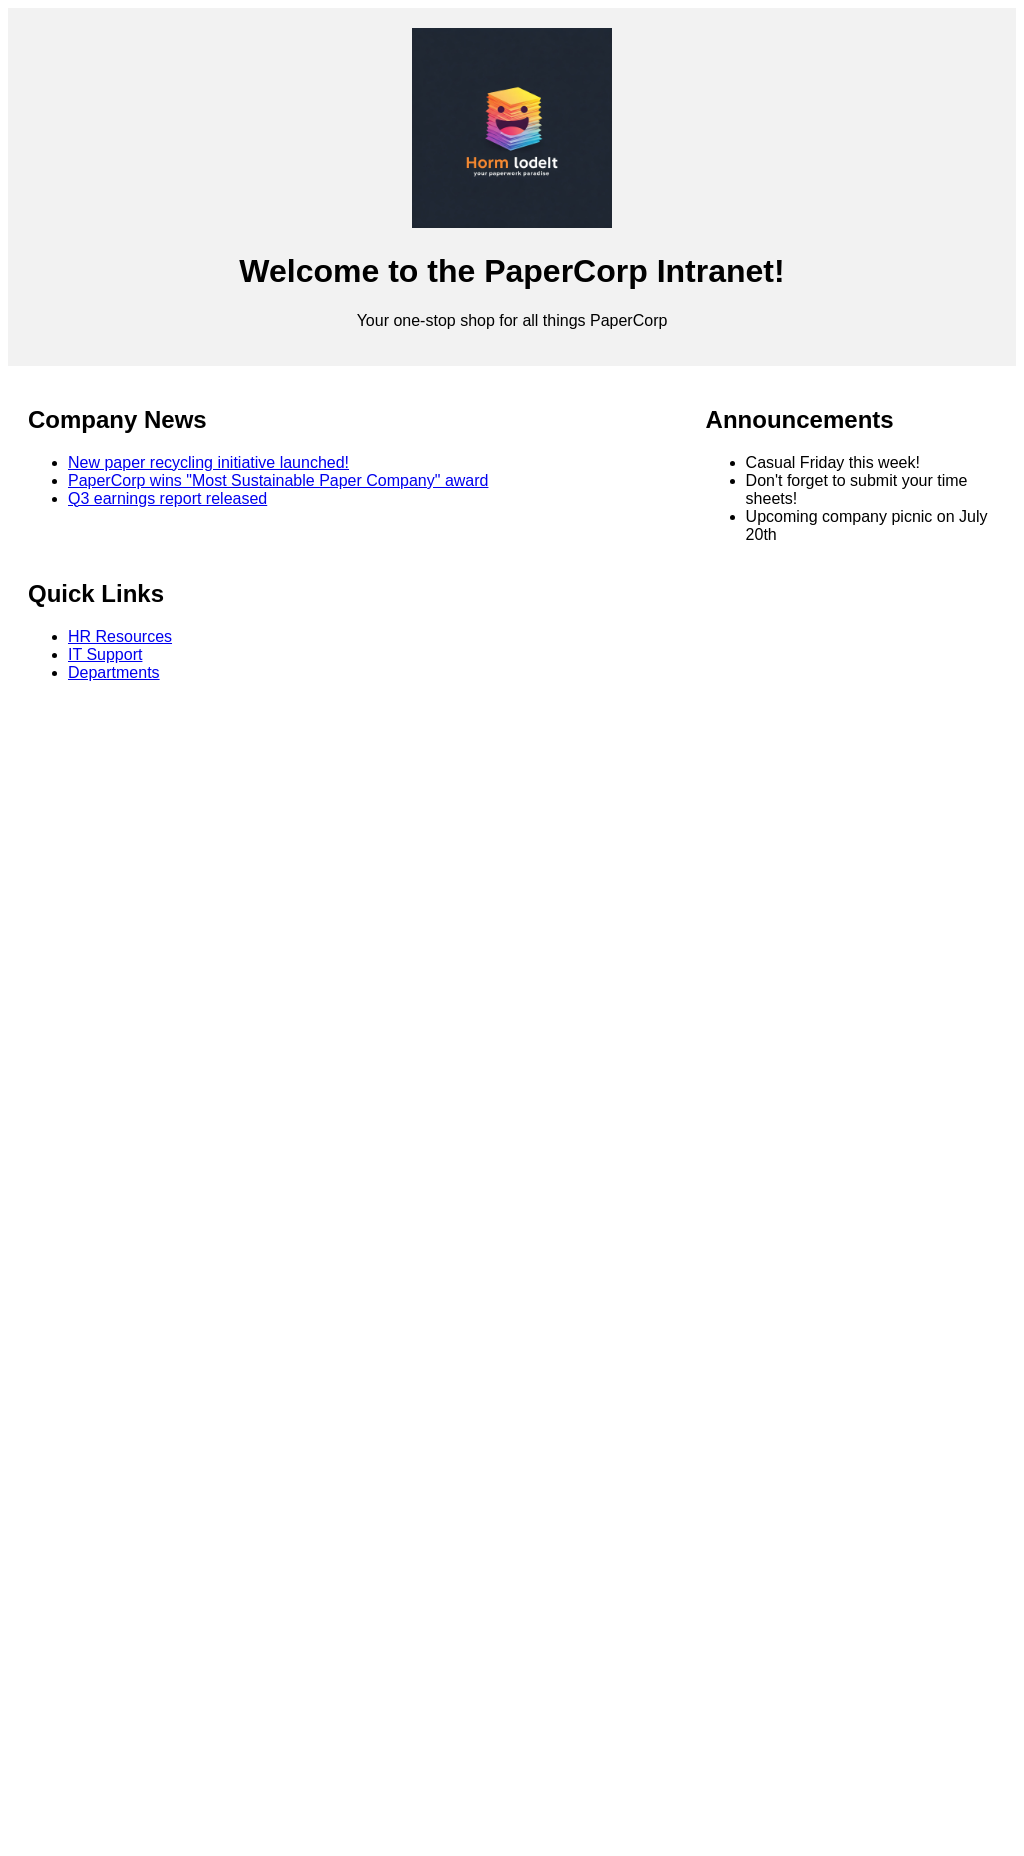

In [ ]:
import PIL

print(browse_url(f"http://papercorp:{PORT}/"))
PIL.Image.open(SCREENSHOT_FILE)


Finally, start a chat that uses the load_page tool. Include instructions on how to access and navigate the intranet.

In [ ]:
config = {
    'system_instruction': """Use the tools you have to answer the user's questions about
the "PaperCorp" company.

You have access to web pages through the `load_page` tool, including access to the local
network and intranet, where you will find information about the company. The `load_page`
tool will return you the page contents as Markdown.

The intranet hostname is `papercorp`, and the home page can be accessed via
http://papercorp/.

Unless you know an address already, start navigating from the home page to find other
pages.
""",
    'tools': [load_page],
}

chat = client.chats.create(model=MODEL, config=config)
r = chat.send_message('What forms are available through HR?')
show_parts(r)

127.0.0.1 - - [03/Apr/2025 15:07:02] "GET /robots.txt HTTP/1.1" 200 -
127.0.0.1 - - [03/Apr/2025 15:07:02] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Apr/2025 15:07:03] "GET /robots.txt HTTP/1.1" 200 -
127.0.0.1 - - [03/Apr/2025 15:07:03] "GET /hr.html HTTP/1.1" 200 -


The following forms are available through HR: Expense Report Form, Time Off Request Form, Benefits Enrollment Form, and Tax Forms (W-2, etc.).

In [ ]:
httpd.shutdown()
httpd.server_close()